## Importing Libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import scipy.io as sio
import matplotlib.pyplot as plt
import numpy as np
import os
import warnings
import tensorflow as tf
from keras import backend as K
from keras import optimizers
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input,Reshape, Conv1D, MaxPooling1D, Flatten, Dense
warnings.filterwarnings('ignore')

## Providing Datapath of the mat files obtained from kaggle

In [3]:
datapath = '/content/drive/MyDrive/archive_1/'

## Defining Functions to load full and partial list of mat files

In [4]:
def load_data_partial(filename):
    mat_contents = sio.loadmat(filename)
    return mat_contents

In [5]:
def load_data(fileDir, exercise):
    word = exercise.lower()
    file_path_list = []
    valid_file_extensions = [".mat"]
    valid_file_extensions = [item.lower() for item in valid_file_extensions]


    for file in os.listdir(fileDir):
        extension = os.path.splitext(file)[1]
        if extension.lower() not in valid_file_extensions:
            continue
        file_path_list.append(os.path.join(fileDir, file))

    Data = []
    for path in file_path_list:
        base=os.path.basename(path)
        base = os.path.splitext(base)[0]
        if word in base:
            print(fileDir+'/%s'%(base))
            mat_contents = sio.loadmat(fileDir+'/%s'%(base))
            val = mat_contents['p']
            total_array = val[0,:] #assigning an array
            Data.append(total_array)

    return Data

### Loading the MAT files

In [6]:
word = 'part'
total_data = load_data(datapath, word)
x =load_data_partial(datapath+str('part_1.mat'))


/content/drive/MyDrive/archive_1//part_1


## Feature Extraction: Extracting PPG ,ECG and ABP values from total_data

In [7]:
PPG = []
ABP = []
ECG = []
for i in range((len(total_data))):
    for j in range(len(total_data[i])):
        k = len(total_data[i][j][0,:])
        for n in range(k//1000):
            ppg = (total_data[i][j][0,(n*1000):(n*1000)+1000]) # Extracting PPG values
            abp = (total_data[i][j][1,(n*1000):(n*1000)+1000]) #Extracting ABP values
            ecg = (total_data[i][j][2,(n*1000):(n*1000)+1000]) #Extracting ECG values
            PPG.append(ppg)
            ABP.append(abp)
            ECG.append(ecg)

# Converting list of PPG,ECG and ABP as array
PPG = np.asarray(PPG)
ABP = np.asarray(ABP)
ECG = np.asarray(ECG)



### Plotting graphs for PPG,ECG and ABP signals

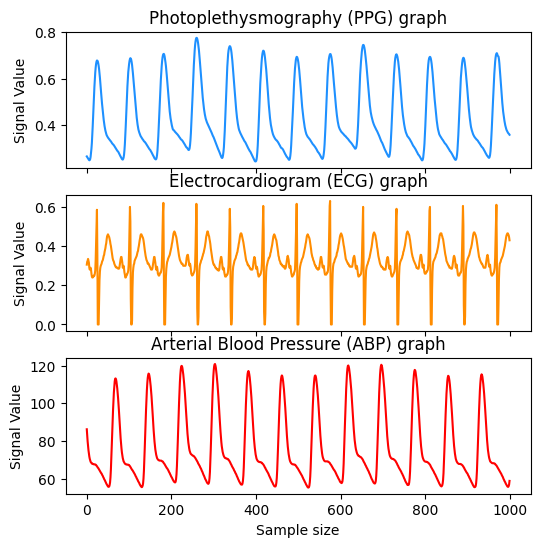

In [8]:
# plotting sample  ppg, ecg and bp signals
fig, ax = plt.subplots(3,1, figsize=(6,6), sharex=True)
y = 1000
ax[0].set_title('Photoplethysmography (PPG) graph', fontsize=12)
ax[0].set_ylabel('Signal Value')
ax[0].plot(PPG[y,:], c = 'dodgerblue')

ax[1].set_title('Electrocardiogram (ECG) graph', fontsize=12)
ax[1].set_ylabel('Signal Value')
ax[1].plot(ECG[y,:], c='darkorange')

ax[2].set_title('Arterial Blood Pressure (ABP) graph', fontsize=12)
ax[2].set_ylabel('Signal Value')
ax[2].set_xlabel('Sample size')
ax[2].plot(ABP[y,:], c = 'red')

### Correlation Estimation

In [9]:
from scipy.stats import pearsonr

# Calculate the correlation between ECG and PPG signals
ecg_ppg_correlation, _ = pearsonr(ECG[:1000].flatten(), PPG[:1000].flatten())
print("Correlation between ECG and PPG signals:", ecg_ppg_correlation)

# Calculate the correlation between ECG and BP signals
ecg_bp_correlation, _ = pearsonr(ECG[:1000].flatten(), ABP[:1000].flatten())
print("Correlation between ECG and ABP signals:", ecg_bp_correlation)

# Calculate the correlation between PPG and BP signals
ppg_bp_correlation, _ = pearsonr(PPG[:1000].flatten(), ABP[:1000].flatten())
print("Correlation between PPG and ABP signals:", ppg_bp_correlation)

Correlation between ECG and PPG signals: -0.27346160018394666
Correlation between ECG and ABP signals: 0.059160138825351025
Correlation between PPG and ABP signals: -0.028087942051436457


## Splitting the data into 70% train and 30% test

**Input** : PPG values

**Output**:  ABP and ECG Values

In [10]:
X_train_PPG, X_test_PPG, y_train_ABP, y_test_ABP, y_train_ECG, y_test_ECG = train_test_split(
    PPG, ABP, ECG, test_size=0.30)

In [11]:
X_train_PPG_reshape = np.reshape(X_train_PPG, (X_train_PPG.shape[0], X_train_PPG.shape[1], 1))

In [12]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense

In [13]:
input_shape = (X_train_PPG_reshape.shape[1],1)
inputs = Input(shape=input_shape)

# Add the first convolutional layer
x = Conv1D(filters=256, kernel_size=3, activation='relu')(inputs)
x = MaxPooling1D(pool_size=2)(x)

# Add additional convolutional layers as needed
x = Conv1D(filters=128, kernel_size=3, activation='relu')(x)
x = MaxPooling1D(pool_size=2)(x)

# Add additional convolutional layers as needed
x = Conv1D(filters=64, kernel_size=3, activation='relu')(x)
x = MaxPooling1D(pool_size=2)(x)

# Flatten the output for further processing
x = Flatten()(x)

# Branch 1 for output 1
bp_output = Dense(units=1000, activation='linear',name='bp_out')(x)

# Branch 2 for output 2
ecg_output = Dense(units=1000, activation='linear',name='ecg_out')(x)

model = Model(inputs=inputs, outputs=[bp_output, ecg_output])

In [14]:
img_file = './model-research-CNN.png'
tf.keras.utils.plot_model(model, to_file=img_file, show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [15]:
model.compile(optimizer='adam',
              loss={'bp_out': 'mse', 'ecg_out': 'mse'},
              metrics={'bp_out': tf.keras.metrics.RootMeanSquaredError(),
                       'ecg_out': tf.keras.metrics.RootMeanSquaredError()})
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 1000, 1)]            0         []                            
                                                                                                  
 conv1d (Conv1D)             (None, 998, 256)             1024      ['input_1[0][0]']             
                                                                                                  
 max_pooling1d (MaxPooling1  (None, 499, 256)             0         ['conv1d[0][0]']              
 D)                                                                                               
                                                                                                  
 conv1d_1 (Conv1D)           (None, 497, 128)             98432     ['max_pooling1d[0][0]']   

### Training a CNN model without Normalized signal values

In [16]:
model.fit(X_train_PPG_reshape, [y_train_ABP, y_train_ECG], batch_size=1024, epochs=20, verbose = 1)

Epoch 1/20
22/22 [==============================] - 31s 1s/step - loss: 4208.1382 - bp_out_loss: 4206.9214 - ecg_out_loss: 1.2164 - bp_out_root_mean_squared_error: 64.8608 - ecg_out_root_mean_squared_error: 1.1029
Epoch 2/20
22/22 [==============================] - 30s 1s/step - loss: 1072.1814 - bp_out_loss: 1071.5740 - ecg_out_loss: 0.6072 - bp_out_root_mean_squared_error: 32.7349 - ecg_out_root_mean_squared_error: 0.7792
Epoch 3/20
22/22 [==============================] - 30s 1s/step - loss: 867.0953 - bp_out_loss: 866.6816 - ecg_out_loss: 0.4138 - bp_out_root_mean_squared_error: 29.4395 - ecg_out_root_mean_squared_error: 0.6433
Epoch 4/20
22/22 [==============================] - 30s 1s/step - loss: 791.0488 - bp_out_loss: 790.6755 - ecg_out_loss: 0.3732 - bp_out_root_mean_squared_error: 28.1190 - ecg_out_root_mean_squared_error: 0.6109
Epoch 5/20
22/22 [==============================] - 30s 1s/step - loss: 708.7491 - bp_out_loss: 708.3831 - ecg_out_loss: 0.3661 - bp_out_root_mean_s

In [17]:
X_test_PPG_reshape = np.reshape(X_test_PPG, (X_test_PPG.shape[0], X_test_PPG.shape[1], 1))

### Evaluating CNN model without Normalization for ABP values

In [18]:
#Predicting on the test set using the CNN model
CNN_predictions = model.predict(X_test_PPG_reshape)
rmse = tf.keras.metrics.RootMeanSquaredError()
rmse.update_state(y_test_ABP, CNN_predictions[0])
print(f'CNN Model RMSE for ABP: {rmse.result().numpy()}')

# MAE for CNN Model
MAE= tf.keras.metrics.MeanAbsoluteError()
MAE.update_state(y_test_ABP, CNN_predictions[0])
print(f'CNN Model MAE for ABP: {MAE.result().numpy()}')

301/301 [==============================] - 4s 14ms/step
CNN Model RMSE for ABP: 18.188379287719727
CNN Model MAE for ABP: 13.980171203613281


In [19]:

#Checking MAP error for CNN model
score = []
for i in range(len(y_test_ABP)):
    score.append(abs(y_test_ABP[i]-CNN_predictions[0][i]))

print("Average MAP error of CNN model is: %f mmHG" %(np.mean(score)))
print("Standard Deviation of CNN Model is: %f mmHG" %(np.std(score)))

Average MAP error of CNN model is: 13.980171 mmHG
Standard Deviation of CNN Model is: 11.634947 mmHG


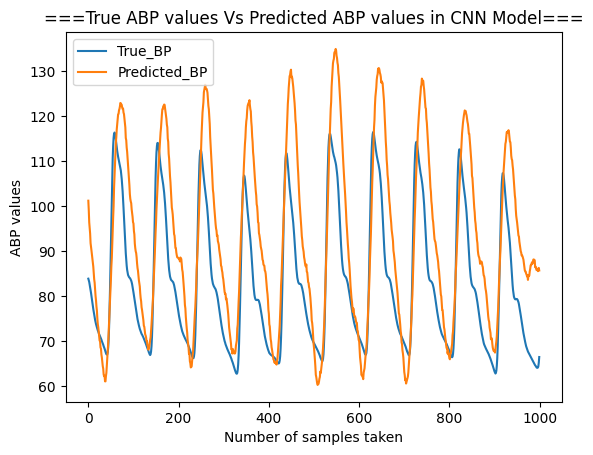

In [20]:
# Visualize predicted BP and the True BP for LSTM model
plt.title("===True ABP values Vs Predicted ABP values in CNN Model===")
plt.xlabel('Number of samples taken')
plt.ylabel('ABP values')
plt.plot(y_test_ABP[1000]) #only plotting 100 samples
plt.plot(CNN_predictions[0][1000])
plt.legend(['True_BP', 'Predicted_BP'])

### Evaluating CNN model without Normalization for ECG values

In [21]:
rmse = tf.keras.metrics.RootMeanSquaredError()
rmse.update_state(y_test_ECG, CNN_predictions[1])
print(f'CNN Model RMSE for ECG values: {rmse.result().numpy()}')

MAE= tf.keras.metrics.MeanAbsoluteError()
MAE.update_state(y_test_ECG, CNN_predictions[1])
print(f'CNN Model MAE for ECG values: {MAE.result().numpy()}')

CNN Model RMSE for ECG values: 0.8882538080215454
CNN Model MAE for ECG values: 0.7068931460380554


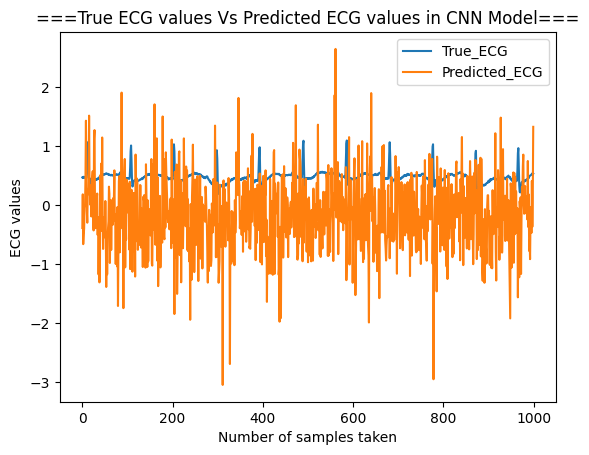

In [22]:
plt.title("===True ECG values Vs Predicted ECG values in CNN Model===")
plt.xlabel('Number of samples taken')
plt.ylabel('ECG values')
plt.plot(y_test_ECG[1000]) #only plotting 100 samples
plt.plot(CNN_predictions[1][1000])
plt.legend(['True_ECG', 'Predicted_ECG'])

## Defining Function to Normalize the PPG and ABP values

In [23]:
def normalise(x):
    normalised = (x-min(x))/(max(x)-min(x))
    return normalised

def scale_abp(x):
    normalised = x/200
    return normalised

def normalise_abp(abp, x_max, x_min):
    normalised = (abp-x_min)/(x_max-x_min)
    return normalised

def abp_maxmin_value(x):
    max_x = []
    min_x = []
    for i in range(len(x)):
        for j in range(len(x[i])):
            max_x.append(max(x[i][j][1,:]))
            min_x.append(min(x[i][j][1,:]))
    x_max = max(max_x)
    x_min = min(min_x)
    return x_max, x_min

### Checking Minimum and Maximum values in total_data

In [24]:
x_max, x_min = abp_maxmin_value(total_data)
print(x_max, x_min)
x_max = 200.0
x_min = 50.0

199.90934525391145 50.01623903864891


## Feature Extraction and Feature Scaling: Extracting PPG ,ECG and ABP values from total_data and normalizing them

In [25]:
# #Data Pre-processing
# # Extracting signal data Feature-extraction
PPG_N = []
ABP_N = []
ECG_N = []
i=0
for j in range(len(total_data[i])):
    k = len(total_data[i][j][0,:])
    for n in range(k//1000):
        ppg_n = normalise(total_data[i][j][0,(n*1000):(n*1000)+1000])
        abp_n = normalise_abp(total_data[i][j][1,(n*1000):(n*1000)+1000], x_max, x_min)
        ecg_n = normalise(total_data[i][j][2,(n*1000):(n*1000)+1000])
        PPG_N.append(ppg_n)
        ABP_N.append(abp_n)
        ECG_N.append(ecg_n)

PPG_N = np.asarray(PPG_N)
ABP_N = np.asarray(ABP_N)
ECG_N = np.asarray(ECG_N)

### Plotting graphs for Normalized PPG,ECG and ABP signals

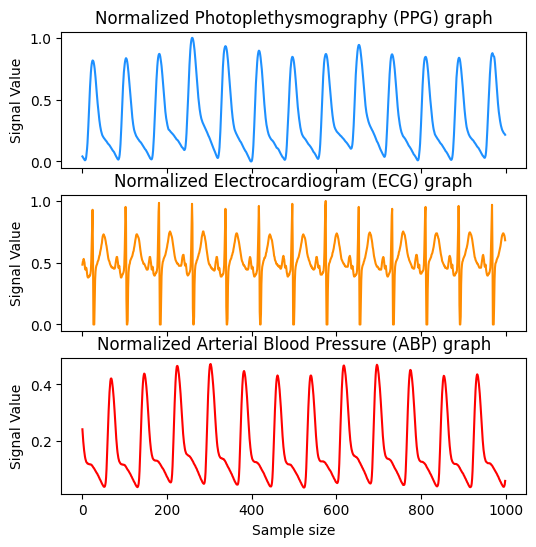

In [26]:
# ##plotting sample normalized ppg, ecg and bp signals
# ##using a sample size of 125
fig, ax = plt.subplots(3,1, figsize=(6,6), sharex=True)
y = 1000
ax[0].set_title('Normalized Photoplethysmography (PPG) graph', fontsize=12)
ax[0].set_ylabel('Signal Value')
ax[0].plot(PPG_N[y,:], c = 'dodgerblue')

ax[1].set_title('Normalized Electrocardiogram (ECG) graph', fontsize=12)
ax[1].set_ylabel('Signal Value')
ax[1].plot(ECG_N[y,:], c='darkorange')

ax[2].set_title('Normalized Arterial Blood Pressure (ABP) graph', fontsize=12)
ax[2].set_ylabel('Signal Value')
ax[2].set_xlabel('Sample size')
ax[2].plot(ABP_N[y,:], c = 'red')

## Splitting the normalized data into 70% train and 30% test
**Input** : *Normalized PPG values*

**Output**: *Normalized ABP and ECG values*

In [27]:
X_train_PPG_N, X_test_PPG_N, y_train_ABP_N, y_test_ABP_N, y_train_ECG_N, y_test_ECG_N = train_test_split(
    PPG_N, ABP_N, ECG_N, test_size=0.30)

In [28]:
X_train_PPG_N_reshape = np.reshape(X_train_PPG_N, (X_train_PPG_N.shape[0], X_train_PPG_N.shape[1], 1))

In [29]:
X_test_PPG_N_reshape =np.reshape(X_test_PPG_N, (X_test_PPG_N.shape[0] ,X_test_PPG_N.shape[1],1))

### Training the CNN Model with Normalized values

In [30]:
model.fit(X_train_PPG_N_reshape, [y_train_ABP_N, y_train_ECG_N], batch_size=1024, epochs=20, verbose = 1)

Epoch 1/20
22/22 [==============================] - 31s 1s/step - loss: 931.1901 - bp_out_loss: 930.8650 - ecg_out_loss: 0.3253 - bp_out_root_mean_squared_error: 30.5101 - ecg_out_root_mean_squared_error: 0.5703
Epoch 2/20
22/22 [==============================] - 31s 1s/step - loss: 1.9832 - bp_out_loss: 1.9246 - ecg_out_loss: 0.0586 - bp_out_root_mean_squared_error: 1.3873 - ecg_out_root_mean_squared_error: 0.2421
Epoch 3/20
22/22 [==============================] - 31s 1s/step - loss: 0.2562 - bp_out_loss: 0.2164 - ecg_out_loss: 0.0398 - bp_out_root_mean_squared_error: 0.4651 - ecg_out_root_mean_squared_error: 0.1995
Epoch 4/20
22/22 [==============================] - 31s 1s/step - loss: 0.1849 - bp_out_loss: 0.1474 - ecg_out_loss: 0.0375 - bp_out_root_mean_squared_error: 0.3839 - ecg_out_root_mean_squared_error: 0.1938
Epoch 5/20
22/22 [==============================] - 31s 1s/step - loss: 0.1663 - bp_out_loss: 0.1293 - ecg_out_loss: 0.0370 - bp_out_root_mean_squared_error: 0.3596 - 

### Evaluating CNN model with Normalized ABP values

In [31]:
#Predicting on the test set using the LSTM model
CNN_predictions_N = model.predict(X_test_PPG_N_reshape)
rmse = tf.keras.metrics.RootMeanSquaredError()
rmse.update_state(y_test_ABP_N, CNN_predictions_N[0])
print(f'CNN Model RMSE for Normalized ABP: {rmse.result().numpy()}')

# MAE for LSTM Model
MAE= tf.keras.metrics.MeanAbsoluteError()
MAE.update_state(y_test_ABP_N, CNN_predictions_N[0])
print(f'CNN Model MAE for Normalized ABP: {MAE.result().numpy()}')

301/301 [==============================] - 6s 18ms/step
CNN Model RMSE for Normalized ABP: 0.17883062362670898
CNN Model MAE for Normalized ABP: 0.14003877341747284


In [32]:
#Scaling back y_test and CNN_predictions to original values to calculate Mean Arterial Pressure (MAP) Error for LSTM model
y_cnn_sb = y_test_ABP_N*(x_max - x_min) +x_min
CNN_pred_sb = CNN_predictions_N[0]*(x_max - x_min) +x_min
score = []
for i in range(len(y_cnn_sb)):
    score.append(abs(y_cnn_sb[i]-CNN_pred_sb[i]))
print("Average MAP error of CNN model is: %f mmHG" %(np.mean(score)))
print("Standard Deviation of CNN Model is: %f mmHG" %(np.std(score)))

Average MAP error of CNN model is: 21.005815 mmHG
Standard Deviation of CNN Model is: 16.682757 mmHG


### Plotting graph for True vs Predicted Normalized ABP values using CNN-LSTM Model

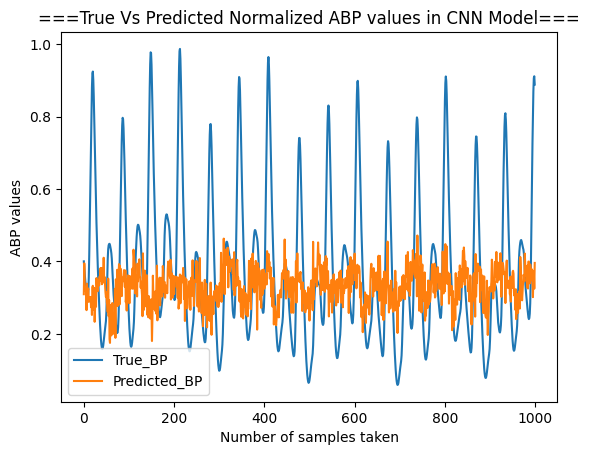

In [33]:
# Visualize predicted BP and the True BP for LSTM model
plt.title("===True Vs Predicted Normalized ABP values in CNN Model===")
plt.xlabel('Number of samples taken')
plt.ylabel('ABP values')
plt.plot(y_test_ABP_N[1000]) #only plotting 100 samples
plt.plot(CNN_predictions_N[0][1000])
plt.legend(['True_BP', 'Predicted_BP'])

### Evaluating CNN model with Normalization for ECG values

In [34]:
rmse = tf.keras.metrics.RootMeanSquaredError()
rmse.update_state(y_test_ECG_N, CNN_predictions_N[1])
print(f'CNN Model RMSE for Normalized ECG: {rmse.result().numpy()}')

# MAE for LSTM Model
MAE= tf.keras.metrics.MeanAbsoluteError()
MAE.update_state(y_test_ECG_N, CNN_predictions_N[1])
print(f'CNN Model MAE for Normalized ECG: {MAE.result().numpy()}')

CNN Model RMSE for Normalized ECG: 0.18765339255332947
CNN Model MAE for Normalized ECG: 0.13797838985919952


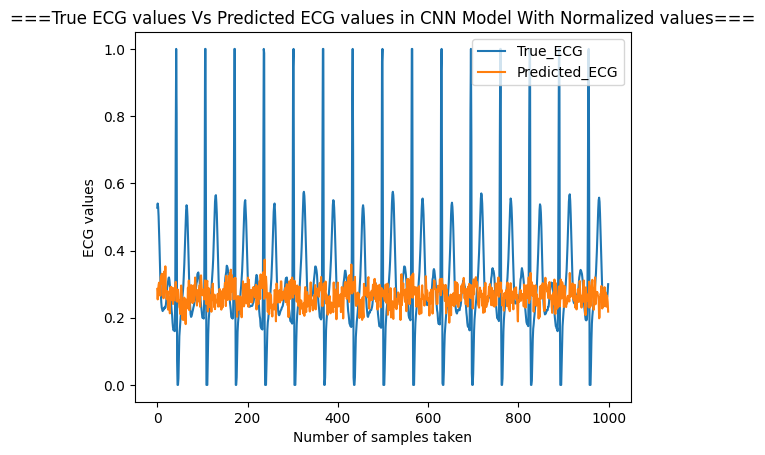

In [35]:
# Visualize predicted BP and the True BP for CNN model
plt.title("===True ECG values Vs Predicted ECG values in CNN Model With Normalized values===")
plt.xlabel('Number of samples taken')
plt.ylabel('ECG values')
plt.plot(y_test_ECG_N[1000]) #only plotting 100 samples
plt.plot(CNN_predictions_N[1][1000])
plt.legend(['True_ECG', 'Predicted_ECG'])

### CNN Model with data augmentation

In [38]:
import numpy as np
from tensorflow.keras.utils import Sequence

class DataGenerator(Sequence):
    def __init__(self, x, y1, y2, batch_size=32, shuffle=True):
        self.x = x
        self.y1 = y1
        self.y2 = y2
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(x))
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.x) / self.batch_size))

    def __getitem__(self, index):
        batch_indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        x_batch = self.x[batch_indexes]
        y1_batch = self.y1[batch_indexes]
        y2_batch = self.y2[batch_indexes]


        return x_batch, [y1_batch, y2_batch]

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)

train_generator = DataGenerator(new_ppg, ABP_N, ECG_N, batch_size=1024)
validation_generator = DataGenerator(new_ppg, ABP_N, ECG_N, batch_size=1024, shuffle=False)

In [37]:
new_ppg= PPG_N.reshape((PPG_N.shape[0],PPG_N.shape[1],1))
new_ppg.shape

(32061, 1000, 1)

In [39]:
train_generator = DataGenerator(new_ppg, ABP_N, ECG_N, batch_size=1024)
validation_generator = DataGenerator(new_ppg, ABP_N, ECG_N, batch_size=1024, shuffle=False)

model.fit(train_generator,
          validation_data=validation_generator,
          epochs=20,
          steps_per_epoch=len(train_generator),
          validation_steps=len(validation_generator))

Epoch 1/20
32/32 [==============================] - 59s 2s/step - loss: 0.0661 - bp_out_loss: 0.0312 - ecg_out_loss: 0.0349 - bp_out_root_mean_squared_error: 0.1768 - ecg_out_root_mean_squared_error: 0.1868 - val_loss: 0.0652 - val_bp_out_loss: 0.0304 - val_ecg_out_loss: 0.0348 - val_bp_out_root_mean_squared_error: 0.1743 - val_ecg_out_root_mean_squared_error: 0.1866
Epoch 2/20
32/32 [==============================] - 59s 2s/step - loss: 0.0645 - bp_out_loss: 0.0297 - ecg_out_loss: 0.0348 - bp_out_root_mean_squared_error: 0.1724 - ecg_out_root_mean_squared_error: 0.1866 - val_loss: 0.0637 - val_bp_out_loss: 0.0290 - val_ecg_out_loss: 0.0347 - val_bp_out_root_mean_squared_error: 0.1704 - val_ecg_out_root_mean_squared_error: 0.1863
Epoch 3/20
32/32 [==============================] - 58s 2s/step - loss: 0.0632 - bp_out_loss: 0.0285 - ecg_out_loss: 0.0347 - bp_out_root_mean_squared_error: 0.1688 - ecg_out_root_mean_squared_error: 0.1862 - val_loss: 0.0626 - val_bp_out_loss: 0.0280 - val_ec

### Evaluating CNN model with Augmented signal Values for ABP

In [40]:
#Predicting on the test set using the LSTM model
CNN_predictions_augment = model.predict(X_test_PPG_N_reshape)
rmse = tf.keras.metrics.RootMeanSquaredError()
rmse.update_state(y_test_ABP_N, CNN_predictions_augment[0])
print(f'CNN Model RMSE for Augmented ABP: {rmse.result().numpy()}')

# MAE for LSTM Model
MAE= tf.keras.metrics.MeanAbsoluteError()
MAE.update_state(y_test_ABP_N, CNN_predictions_augment[0])
print(f'CNN Model MAE for Augented ABP: {MAE.result().numpy()}')

301/301 [==============================] - 5s 16ms/step
CNN Model RMSE for Augmented ABP: 0.14466430246829987
CNN Model MAE for Augented ABP: 0.11395572870969772


In [41]:
#Scaling back y_test and CNN_predictions to original values to calculate Mean Arterial Pressure (MAP) Error for LSTM model
y_cnn_sb = y_test_ABP_N*(x_max - x_min) +x_min
CNN_pred_sb = CNN_predictions_augment[0]*(x_max - x_min) +x_min
score = []
for i in range(len(y_cnn_sb)):
    score.append(abs(y_cnn_sb[i]-CNN_pred_sb[i]))
print("Average MAP error of CNN model is: %f mmHG" %(np.mean(score)))
print("Standard Deviation of CNN Model is: %f mmHG" %(np.std(score)))

Average MAP error of CNN model is: 17.093360 mmHG
Standard Deviation of CNN Model is: 13.367559 mmHG


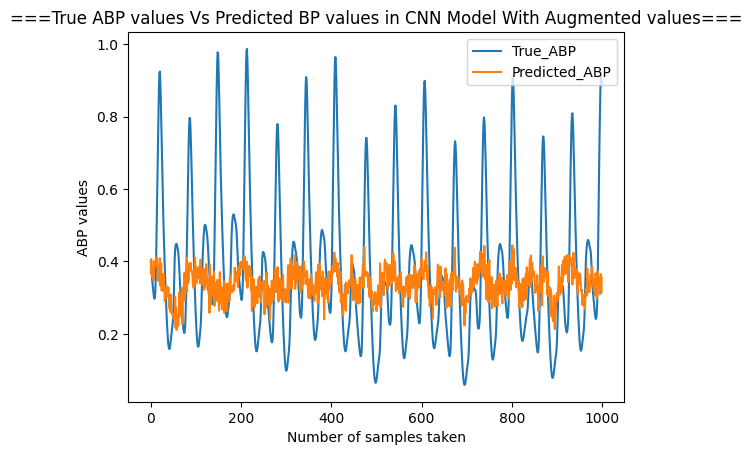

In [42]:
# Visualize predicted BP and the True BP for LSTM model
plt.title("===True ABP values Vs Predicted BP values in CNN Model With Augmented values===")
plt.xlabel('Number of samples taken')
plt.ylabel('ABP values')
plt.plot(y_test_ABP_N[1000]) #only plotting 100 samples
plt.plot(CNN_predictions_augment[0][1000])
plt.legend(['True_ABP', 'Predicted_ABP'])

### Evaluating CNN model with Augmented ECG values

In [43]:
rmse = tf.keras.metrics.RootMeanSquaredError()
rmse.update_state(y_test_ECG_N, CNN_predictions_augment[1])
print(f'CNN Model RMSE for Augmented ECG: {rmse.result().numpy()}')

# MAE for LSTM Model
MAE= tf.keras.metrics.MeanAbsoluteError()
MAE.update_state(y_test_ECG_N, CNN_predictions_augment[1])
print(f'CNN Model MAE for Augmented ECG: {MAE.result().numpy()}')

CNN Model RMSE for Augmented ECG: 0.18479764461517334
CNN Model MAE for Augmented ECG: 0.13687202334403992


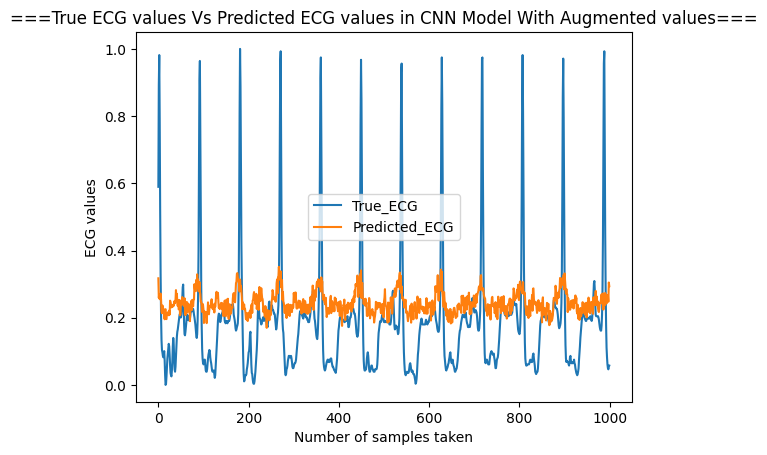

In [44]:
# Visualize predicted BP and the True BP for LSTM model
plt.title("===True ECG values Vs Predicted ECG values in CNN Model With Augmented values===")
plt.xlabel('Number of samples taken')
plt.ylabel('ECG values')
plt.plot(y_test_ECG_N[5]) #only plotting 100 samples
plt.plot(CNN_predictions_augment[1][5])
plt.legend(['True_ECG', 'Predicted_ECG'])